In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import time
from datetime import datetime
import matplotlib.pyplot as plt
 
plt.style.use(['science','notebook'])
plt.style.reload_library()

In [3]:
from june import World 
from june.geography import Geography
from june.demography import Demography
from june.interaction import Interaction
from june.infection import Infection, HealthIndexGenerator, InfectionSelector
from june.infection.transmission import TransmissionConstant
from june.groups import Hospitals, Schools, Companies, Households, CareHomes, Cemeteries, Universities
from june.groups.leisure import generate_leisure_for_config, Cinemas, Pubs, Groceries
from june.groups.travel import *
from june.simulator import Simulator
from june.infection_seed import InfectionSeed
from june.policy import Policy, Policies
from june import paths
from june.hdf5_savers import load_geography_from_hdf5
from june.logger.read_logger import ReadLogger
from june.world import generate_world_from_geography
from june.hdf5_savers import generate_world_from_hdf5

No --data argument given - defaulting to:
/home/arnau/code/JUNE/data
No --configs argument given - defaulting to:
/home/arnau/code/JUNE/configs


# Initialize world

To initialize a certain world, we need to add the different components we want to have in it. First we specify what super areas (msoa) we want to create. We have included these ones, because they are known to contain hospitals, schools, care homes, and companies.

After creating the geography, we create the different components the worlds need to have such as care homes, companies ...

In [4]:
CONFIG_PATH = paths.configs_path / "config_example.yaml"

In [5]:
%%time 

geography = Geography.from_file(
        {
            "super_area": ["E02001731", "E02002566"]
        }
)

geography.hospitals = Hospitals.for_geography(geography)
geography.schools = Schools.for_geography(geography)
geography.companies = Companies.for_geography(geography)
geography.care_homes = CareHomes.for_geography(geography)
geography.universities = Universities.for_super_areas(geography.super_areas)
world = generate_world_from_geography(geography, include_households=True)


2020-09-16 12:25:49,012 - june.geography.geography - INFO - There are 67 areas and 2 super_areas in the world.
2020-09-16 12:25:49,017 - june.groups.hospital - INFO - There are 1 hospitals in this geography.
2020-09-16 12:25:49,051 - june.groups.school - INFO - There are 7 schools in this geography.
2020-09-16 12:25:49,064 - june.groups.school - INFO - No school for the age 0 in this world.
2020-09-16 12:25:49,069 - june.groups.school - INFO - No school for the age 1 in this world.
2020-09-16 12:25:49,098 - june.groups.school - INFO - No school for the age 12 in this world.
2020-09-16 12:25:49,101 - june.groups.school - INFO - No school for the age 13 in this world.
2020-09-16 12:25:49,311 - june.groups.carehome - INFO - There are 4 care_homes in this geography.
2020-09-16 12:25:56,879 - june.distributors.worker_distributor - INFO - There are 0 who had to be told to stay real
CPU times: user 9.78 s, sys: 503 ms, total: 10.3 s
Wall time: 10.3 s


## Commute, travel and leisure

In [6]:
world.pubs = Pubs.for_geography(geography)
world.cinemas = Cinemas.for_geography(geography)
world.groceries = Groceries.for_geography(geography)
leisure = generate_leisure_for_config(world, config_filename=CONFIG_PATH)
leisure.distribute_social_venues_to_households(world.households, super_areas=world.super_areas) # this assigns possible social venues to people.

2020-09-16 12:25:59,316 - june.groups.leisure.leisure - INFO - Distributing social venues to households
2020-09-16 12:25:59,317 - june.groups.leisure.leisure - INFO - Distributed in 0 of 9123 households.


We are also going to need some cemeteries...geography.cemeteries = Cemeteries()


In [7]:
# initialise commuting
travel = Travel()
travel.initialise_commute(world)

2020-09-16 12:26:03,865 - june.groups.travel.travel - INFO - Creating cities...
2020-09-16 12:26:03,878 - june.geography.station - INFO - Station Newcastle initialised.
2020-09-16 12:26:10,111 - june.groups.travel.travel - INFO - Assigning commuters to stations...
2020-09-16 12:26:10,112 - june.groups.travel.travel - INFO - Assigned 0 of 19199 commuters...
2020-09-16 12:26:10,116 - june.groups.travel.travel - INFO - Commuters assigned
2020-09-16 12:26:10,117 - june.groups.travel.travel - INFO - Creating transport units for the population
2020-09-16 12:26:10,118 - june.groups.travel.travel - INFO - Cities' transport initialised


In [8]:
world.cemeteries = Cemeteries()

In [9]:
len(world.people)

19199

### If it took a long time to run the previous commands, it might be a good idea to save the world to reuse it later.

In [10]:
world.to_hdf5("world.hdf5")

2020-09-16 12:26:10,184 - june.hdf5_savers.world_saver - INFO - saving world to HDF5
2020-09-16 12:26:10,481 - june.hdf5_savers.world_saver - INFO - saving hospitals...
2020-09-16 12:26:10,484 - june.hdf5_savers.world_saver - INFO - saving schools...
2020-09-16 12:26:10,488 - june.hdf5_savers.world_saver - INFO - saving companies...
2020-09-16 12:26:10,497 - june.hdf5_savers.world_saver - INFO - saving households...
2020-09-16 12:26:10,797 - june.hdf5_savers.world_saver - INFO - saving care homes...
2020-09-16 12:26:10,799 - june.hdf5_savers.world_saver - INFO - saving cities...
2020-09-16 12:26:10,803 - june.hdf5_savers.world_saver - INFO - saving stations...
2020-09-16 12:26:10,806 - june.hdf5_savers.world_saver - INFO - saving universities...
2020-09-16 12:26:10,810 - june.hdf5_savers.world_saver - INFO - saving social venues...


If we would like to load the world we saved, we just do

In [11]:
world = generate_world_from_hdf5("world.hdf5")

2020-09-16 12:26:10,840 - june.hdf5_savers.world_saver - INFO - loading world from HDF5
2020-09-16 12:26:10,845 - june.hdf5_savers.world_saver - INFO - loading hospitals...
2020-09-16 12:26:10,848 - june.hdf5_savers.world_saver - INFO - loading schools...
2020-09-16 12:26:10,852 - june.hdf5_savers.world_saver - INFO - loading companies...
2020-09-16 12:26:10,904 - june.hdf5_savers.world_saver - INFO - loading care homes...
2020-09-16 12:26:10,906 - june.hdf5_savers.world_saver - INFO - loading universities...
2020-09-16 12:26:10,909 - june.hdf5_savers.world_saver - INFO - loading cities...
2020-09-16 12:26:10,916 - june.hdf5_savers.world_saver - INFO - loading stations...
2020-09-16 12:26:10,920 - june.hdf5_savers.world_saver - INFO - loading households...
2020-09-16 12:26:11,033 - june.hdf5_savers.world_saver - INFO - loading population...
2020-09-16 12:26:11,148 - june.hdf5_savers.world_saver - INFO - loading social venues...
2020-09-16 12:26:11,156 - june.hdf5_savers.world_saver - I

In [12]:
# and regenerate leisure in case we load it externally
leisure = generate_leisure_for_config(world, CONFIG_PATH)
# create travel as well
travel = Travel()

you have now a beautiful pre-pandemic world. 

# Adding the infection

The module in charge of infecting people is called the ``InfectionSelector``, which gives people a transmission time profile and a symptoms trajectory based on their age and sex (through the health index generator)

In [13]:
health_index_generator = HealthIndexGenerator.from_file(asymptomatic_ratio=0.2)
selector = InfectionSelector.from_file(
        health_index_generator=health_index_generator,
        transmission_config_path=paths.configs_path / 'defaults/transmission/XNExp.yaml'
)

# Adding the interaction

In [14]:
interaction = Interaction.from_file()

Beta are the intensities of the interaction taking place at the different groups

In [15]:
for key in interaction.beta.keys():
    interaction.beta[key] *= 0.2

In [16]:
interaction.beta

{'box': 0.2,
 'pub': 0.1,
 'grocery': 0.05,
 'cinema': 0.05,
 'city_transport': 0.1,
 'inter_city_transport': 0.1,
 'hospital': 0.010000000000000002,
 'care_home': 0.24,
 'company': 0.16000000000000003,
 'school': 0.16000000000000003,
 'household': 0.2,
 'university': 0.1}

moreover this interaction module uses contact matrices, that are different for different groups. These contact matrices shouldnt be modified for now. However they are a combination of conversational contact matrices, and physical contact matrices (see the BBC pandemic paper, from where these matrices are extracted https://www.medrxiv.org/content/10.1101/2020.02.16.20023754v2)

There is a parameter, ``alpha`` ($\alpha$), that combines these two matrices in the following way,


$\beta M \left(1 + (\alpha -1) \right) P$

where $\beta$ is the intensity of the interaction, and $P$ the physical contact matrix. A larger $\alpha$ produces more physical contacts. It is an overall number, non dependent of the particular group.


In [17]:
interaction.alpha_physical

2.0

# Seed the disease

There are two options implemented in the seed at the moment, either you specify the number of cases and these are then homogeneously distributed by population to the different areas, or you use UK data on cases per region. For now use the first case.

In [18]:
infection_seed = InfectionSeed(
    world.super_areas, selector,
)

In [19]:
n_cases = 50
infection_seed.unleash_virus(n_cases) # play around with the initial number of cases

# Set policies

In [20]:
policies = Policies.from_file()

In [21]:
policies

# Run the simulation

The simulator is the main module in charge of running the simulation. It coordinates the ``ActivityManager`` which is responsible of allocating people to the right groups given the current timestep, it updates the health status of the population, and it runs the interaction over the different groups. All of these modules can be modified by policies at any given time.

Since the timer configuration is a bit cumbersome, it is read from the config file at ``configs/config_example.yaml``

In [22]:
simulator = Simulator.from_file(
    world=world,
    infection_selector=selector,
    interaction=interaction, 
    config_filename = CONFIG_PATH,
    leisure = leisure,
    travel = travel,
    policies = policies
)

In [23]:
%%time
simulator.run()

2020-09-16 12:26:14,447 - june.simulator - INFO - Starting group_dynamics for 40 days at day 0
2020-09-16 12:26:14,448 - june.simulator - INFO - starting the loop ..., at 0 days, to run for 40 days
2020-09-16 12:26:15,121 - june.simulator - INFO - Date = 2020-03-01 00:00:00, number of deaths =  0, number of infected = 50
2020-09-16 12:26:15,387 - june.simulator - INFO - Date = 2020-03-01 04:00:00, number of deaths =  0, number of infected = 50
2020-09-16 12:26:15,569 - june.simulator - INFO - Date = 2020-03-01 08:00:00, number of deaths =  0, number of infected = 50
2020-09-16 12:26:15,672 - june.simulator - INFO - Date = 2020-03-01 12:00:00, number of deaths =  0, number of infected = 50
2020-09-16 12:26:15,817 - june.simulator - INFO - Date = 2020-03-02 00:00:00, number of deaths =  0, number of infected = 50
2020-09-16 12:26:15,945 - june.simulator - INFO - Date = 2020-03-02 01:00:00, number of deaths =  0, number of infected = 50
2020-09-16 12:26:16,389 - june.simulator - INFO - Da

While the simulation runs (and afterwards) we can launch the visualization webpage by running
```python june/visualizer.py path/to/results``` 

# Getting the results

All results are stored in a json file specified in the ``save_path`` variable in the config file. We can also access it from ``world.logger`` directly.

In [24]:
import pandas as pd

In [25]:
%%time
read = ReadLogger()

CPU times: user 401 ms, sys: 0 ns, total: 401 ms
Wall time: 402 ms


## Hospital data and how it changed over time

In [26]:
hospitals_characteristics_df = read.load_hospital_characteristics()

In [27]:
hospitals_characteristics_df

,longitude,latitude,n_beds,n_icu_beds,trust_code
0,-1.563477,54.53125,905,128,RXP


In [28]:
hospitals_df = read.load_hospital_capacity()

In [29]:
hospitals_df

,id,n_patients,n_patients_icu
time_stamp,,,
2020-03-01 00:00:00,0,0,0
2020-03-01 04:00:00,0,0,0
2020-03-01 08:00:00,0,0,0
2020-03-01 12:00:00,0,0,0
2020-03-02 00:00:00,0,0,0
...,...,...,...
2020-04-09 00:00:00,0,8,1
2020-04-09 01:00:00,0,8,1
2020-04-09 09:00:00,0,9,1


## where did infections happen?

In [30]:
read.load_infection_location()

In [31]:
infection_locations = read.get_locations_infections()

In [32]:
unique_locations, counts_locations = np.unique(
                np.array(infection_locations),
                return_counts=True)

location_counts_df = pd.DataFrame(
    {'locations': unique_locations,
    'counts': counts_locations}
)
location_counts_df.set_index('locations', inplace=True)

In [33]:
location_counts_df['percent_infections']= 100*(location_counts_df['counts'])/location_counts_df.values.sum()

Text(0.5, 0, 'location')

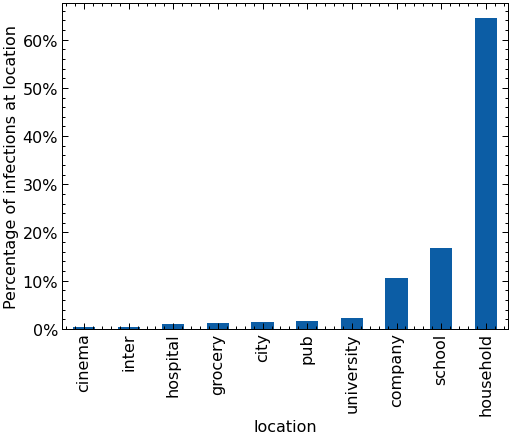

In [34]:
import matplotlib.ticker as mtick

ax = location_counts_df['percent_infections'].sort_values().plot.bar()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ylabel('Percentage of infections at location')
plt.xlabel('location')


You can use the location id column to find where outbreaks happend and how many people got infected at that location

In [35]:
unique_id, count_id =  np.unique(
        np.array(read.locations_df['location_id'].sum()),
        return_counts=True
)

In [36]:
unique_id[np.argsort(count_id)[-5:]]

array(['school_1', 'company_1348', 'university_0', 'school_5', 'school_6'],
      dtype='<U20')

In [37]:
count_id[np.argsort(count_id)[-5:]]

array([ 30,  31,  43,  59, 194])

Alternatively, use the location time series to see where people get infected as a function of time (per week or per day)

In [38]:
weekly_infections=read.locations_df.resample('W').sum()

In [39]:
for location in unique_locations:
    weekly_infections[str(location)] = weekly_infections.apply(
        lambda x: x.location.count(str(location)), axis=1
    )

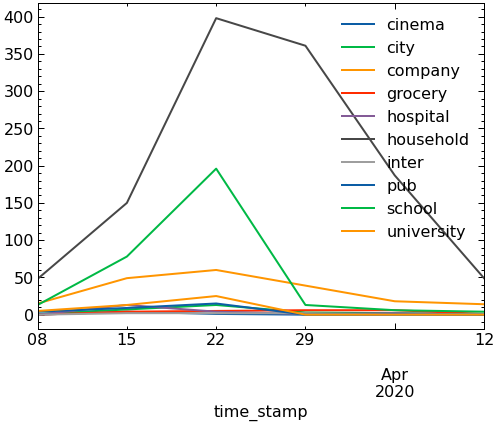

In [40]:
weekly_infections.iloc[:,3:].plot()

In [41]:
for location in unique_locations:
    read.locations_df[str(location)] = read.locations_df.apply(
        lambda x: x.location.count(str(location)), axis=1
    )

In [42]:
read.locations_df.index = pd.to_datetime(read.locations_df.index)


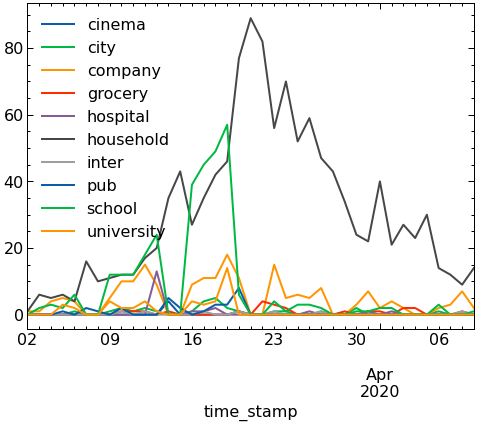

In [43]:
read.locations_df.iloc[:,3:].plot()

## rate of infection

In [44]:
r_df = read.get_r()

/home/arnau/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/arnau/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, 'R')

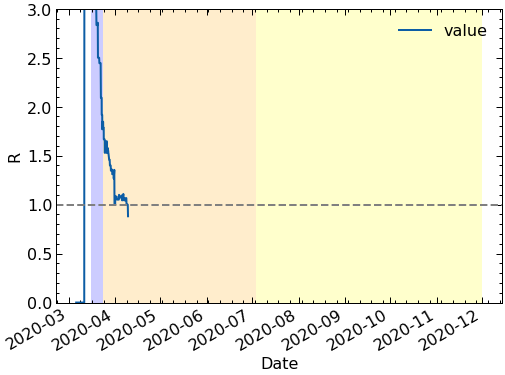

In [45]:
from june.policy import SocialDistancing
r_df.plot()
colors = ["yellow", "orange", 'blue']
for policy in policies.policies:
    if isinstance(policy, SocialDistancing):
        plt.axvspan(policy.start_time, 
                policy.end_time,
                facecolor=colors.pop(),
                alpha=0.2)
plt.axhline(y=1, linestyle='dashed', color='gray')
plt.xlabel('Date')
plt.ylim(0,3)
plt.ylabel('R')

## World infection curves, and by super area

In [46]:
%%time
world_df = read.world_summary()

CPU times: user 159 ms, sys: 3.34 ms, total: 163 ms
Wall time: 163 ms


/home/arnau/.local/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/home/arnau/code/JUNE/june/logger/read_logger.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  symptoms_df.loc[ts,col] = data[mask]


Text(0.5, 0, 'Date')

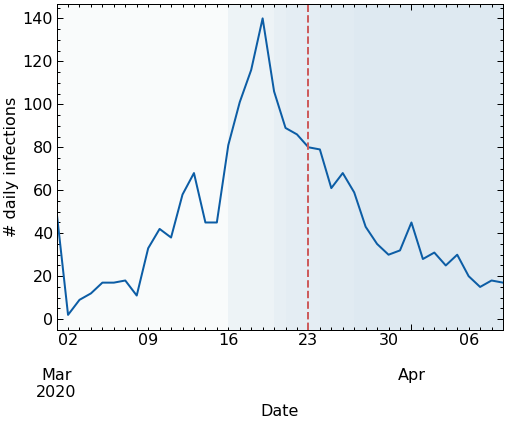

In [47]:
fig, ax = plt.subplots()
world_df['daily_infections'].resample('D').sum().plot(ax=ax)
for policy in policies.policies:
    plt.axvspan(policy.start_time, 
                policy.end_time,
                alpha=0.01)
plt.axvline('2020-03-23',
           linestyle='dashed',
           color='indianred')
ax.set_ylabel('# daily infections')
ax.set_xlabel('Date')

Text(0.5, 0, 'Date')

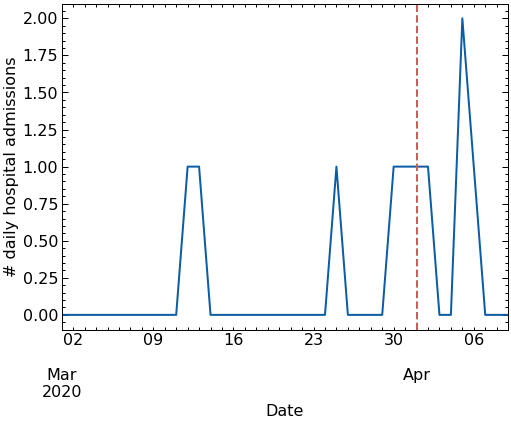

In [48]:
fig, ax = plt.subplots()
world_df['daily_hospital_admissions'].resample('D').sum().plot(ax=ax)

plt.axvline('2020-04-01',
           linestyle='dashed',
           color='indianred')
ax.set_ylabel('# daily hospital admissions')
ax.set_xlabel('Date')

Text(0.5, 0, 'Date')

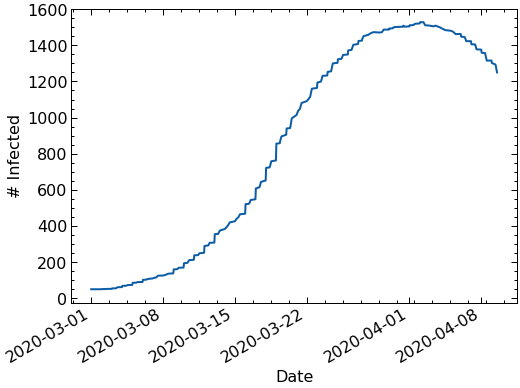

In [49]:
fig, ax = plt.subplots()
world_df['current_infected'].plot(ax=ax)

ax.set_ylabel('# Infected')
ax.set_xlabel('Date')

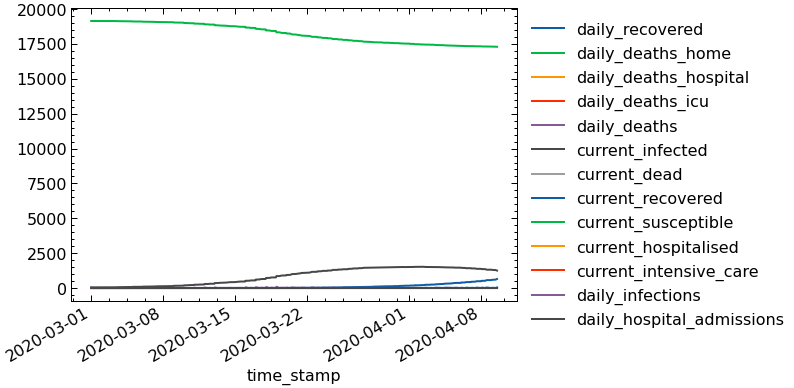

In [50]:
world_df.plot()

plt.legend(bbox_to_anchor=(1,1))


In [51]:
%%time
run_summary = read.run_summary()

/home/arnau/.local/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/home/arnau/code/JUNE/june/logger/read_logger.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  symptoms_df.loc[ts,col] = data[mask]


CPU times: user 597 ms, sys: 23.3 ms, total: 620 ms
Wall time: 621 ms


In [52]:
run_summary

,super_area,current_infected,current_dead,current_recovered,current_susceptible,current_hospitalised,current_intensive_care,daily_recovered,daily_deaths_home,daily_deaths_hospital,daily_deaths_icu,daily_deaths,daily_infections,daily_hospital_admissions,region,location_id
time_stamp,,,,,,,,,,,,,,,,
2020-03-01,E02001731,33,0,0,12248,0,0,0,0,0,0,0,33,0.0,North East,NaN
2020-03-02,E02001731,34,0,0,12247,0,0,0,0,0,0,0,2,0.0,North East,"[company_1700, household_9047]"
2020-03-03,E02001731,36,0,0,12244,0,0,0,0,0,0,0,6,0.0,North East,"[company_4045, household_5077, household_5077,..."
2020-03-04,E02001731,44,0,0,12236,0,0,0,0,0,0,0,5,0.0,North East,"[school_1, company_85, company_1348, company_4..."
2020-03-05,E02001731,55,0,0,12226,0,0,0,0,0,0,0,13,0.0,North East,"[household_8378, school_6, company_8, company_..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-05,E02002566,648,0,142,6127,1,1,23,0,0,0,0,7,0.0,North East,"[household_406, household_2025, household_2555..."
2020-04-06,E02002566,631,0,166,6119,1,1,28,0,0,0,0,6,0.0,North East,"[household_2579, school_1, school_4, company_1..."
2020-04-07,E02002566,608,0,195,6114,1,1,27,0,0,0,0,5,0.0,North East,"[household_49, company_258, company_1348, hous..."


In [53]:
regional_run_summary = run_summary.groupby(['region', run_summary.index]).sum()

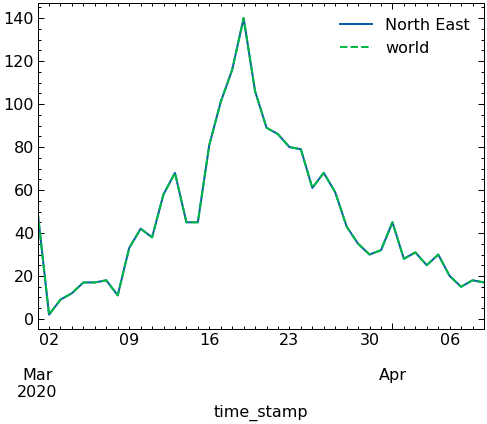

In [54]:
regional_run_summary.loc['North East']['daily_infections'].plot(label='North East')
world_df['daily_infections'].resample('D').sum().plot(linestyle='dashed', label='world')
plt.legend()

## World infection curves per age group

In [55]:
%%time
ages_df = read.age_summary([0,10,20,30,40,
                  50,60,70,80,90,100])

/home/arnau/.local/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/home/arnau/code/JUNE/june/logger/read_logger.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  symptoms_df.loc[ts,col] = data[mask]


CPU times: user 1.96 s, sys: 15.8 ms, total: 1.97 s
Wall time: 2 s


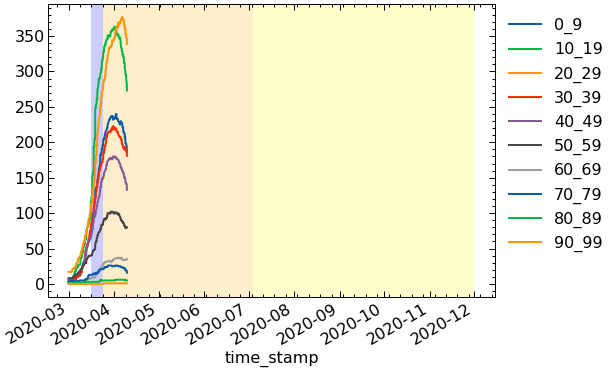

In [56]:
for name, group in ages_df.groupby('age_range'):
    group['current_infected'].plot(label=name)
colors = ["yellow", "orange","blue"]
for policy in policies.policies:
    if isinstance(policy, SocialDistancing):
        plt.axvspan(policy.start_time, 
                policy.end_time,
                facecolor=colors.pop(), alpha=0.2)
plt.legend(bbox_to_anchor=(1,1))


## Draw some of the symptoms trajectories

In [57]:
random_trajectories = read.draw_symptom_trajectories(window_length=600,
                                        n_people=10)

In [58]:
from june.infection import SymptomTag

In [59]:
symptoms_values = [tag.value for tag in SymptomTag]
symptoms_names = [tag.name for tag in SymptomTag]


Text(0.5, 0, 'Date')

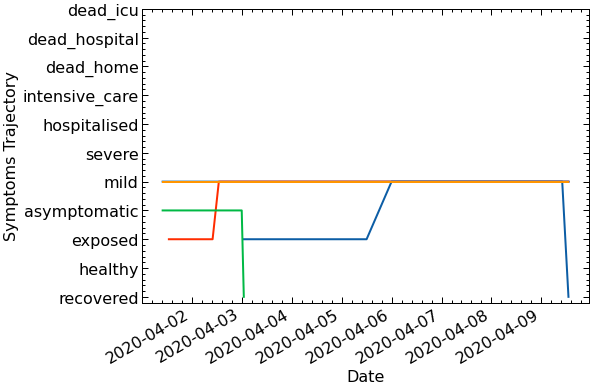

In [60]:
for df_person in random_trajectories:
    df_person['symptoms'].plot()
plt.ylabel('Symptoms Trajectory')
_ = plt.yticks(symptoms_values, symptoms_names)
plt.xlabel('Date')

Text(0.5, 0, 'Date')

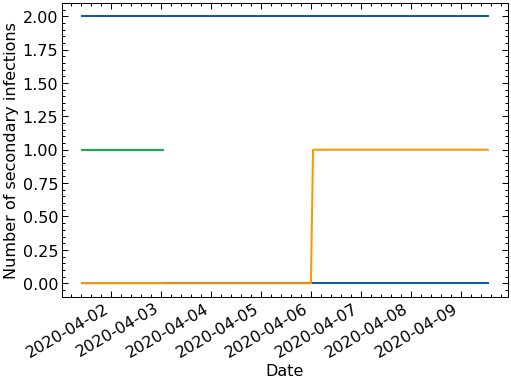

In [61]:
for df_person in random_trajectories:
    df_person['n_secondary_infections'].plot()
plt.ylabel('Number of secondary infections')

plt.xlabel('Date')